In [1]:
import scipy
from math import sqrt
from scipy import stats
from numpy import cov, linspace
from statistics import mean
from numpy.random import normal
import matplotlib.pyplot as plt
from random import random
from collections import defaultdict
%matplotlib inline

In [2]:
def draw(p):
    if random() < p:
        return 1
    else:
        return 0

def lmd(x):
    return list(map(draw, x))

def get_AB_samples(before_p, offset_p, treatment_lift, N):
    A_before = [int(random() < before_p) for _ in range(N)]
    B_before = [int(random() < before_p) for _ in range(N)]
    A_after  = [int(random() < abs(x - offset_p))                  for x in A_before]
    B_after  = [int(random() < abs(x - offset_p) + treatment_lift) for x in B_before]
    return lmd(A_before), lmd(B_before), lmd(A_after), lmd(B_after)

def get_cuped_adjusted(A_before, B_before, A_after, B_after):
    cv = cov([A_after + B_after, A_before + B_before])
    theta = cv[0, 1] / cv[1, 1]
    mean_before = mean(A_before + B_before)
    A_after_adjusted = [after - (before - mean_before) * theta for after, before in zip(A_after, A_before)]
    B_after_adjusted = [after - (before - mean_before) * theta for after, before in zip(B_after, B_before)]
    return A_after_adjusted, B_after_adjusted

def get_cuped_adjusted_lr(A_before, B_before, A_after, B_after):
    lr = stats.linregress(A_before + B_before, A_after + B_after)
    mean_after = mean(A_after + B_after)
    A_after_adjusted = [mean_after + after - (lr.intercept + before * lr.slope) for after, before in zip(A_after, A_before)]
    B_after_adjusted = [mean_after + after - (lr.intercept + before * lr.slope) for after, before in zip(B_after, B_before)]
    return A_after_adjusted, B_after_adjusted

def lift(A, B):
    return mean(B) - mean(A)

def expected_lift_ratio(A_before, B_before, A_after, B_after):
    cv = cov([A_after + B_after, A_before + B_before])
    corr = cv[0, 1] / (sqrt(cv[0, 0]) * sqrt(cv[1, 1]))
    return 1 - corr**2

def p_value(A, B):
    return stats.ttest_ind(A, B)[1]

In [3]:
N = 10*1000
before_p = 0.1
offset_p = 0.1
treatment_lift = 0.01

A_before, B_before, A_after, B_after = get_AB_samples(before_p, offset_p, treatment_lift, N)
A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)

print('A mean before = %.3f, A mean after = %.3f, A mean after adjusted = %.3f' % (mean(A_before), mean(A_after), mean(A_after_adjusted)))
print('B mean be|fore = %.3f, B mean after = %.3f, B mean after adjusted = %.3f' % (mean(B_before), mean(B_after), mean(B_after_adjusted)))
print('Traditional    A/B test evaluation, lift = %.3f, p-value = %.3f' % (lift(A_after, B_after), p_value(A_after, B_after)))
print('CUPED adjusted A/B test evaluation, lift = %.3f, p-value = %.3f' % (lift(A_after_adjusted, B_after_adjusted), p_value(A_after_adjusted, B_after_adjusted)))

A mean before = 0.101, A mean after = 0.178, A mean after adjusted = 0.178
B mean be|fore = 0.100, B mean after = 0.186, B mean after adjusted = 0.186
Traditional    A/B test evaluation, lift = 0.008, p-value = 0.133
CUPED adjusted A/B test evaluation, lift = 0.008, p-value = 0.052


In [4]:
print('Possible mappings:')
mappings = set(['(before=%d, after=%d) -> adjusted=%.3f' % (b, a, p) for
  b, a, p in zip(A_before+B_before, A_after+B_after, A_after_adjusted+B_after_adjusted)])
for m in mappings:
    print(m)

Possible mappings:
(before=1, after=0) -> adjusted=-0.722
(before=0, after=1) -> adjusted=1.081
(before=0, after=0) -> adjusted=0.081
(before=1, after=1) -> adjusted=0.278


In [5]:
counts = defaultdict(int)
for b, a in zip(A_before, A_after):
    counts[(b, a)] += 1
    counts[(b)] += 1

print('P(before = 0) = %.2f' % (counts[(0)]/(counts[(0)]+counts[(1)])))
print('(after = 1 | before = 0) = %.2f' % (counts[(0, 1)]/counts[(0)]))
print('(after = 0 | before = 0) = %.2f' % (counts[(0, 0)]/counts[(0)]))
print('P(before = 1) = %.2f' % (counts[(1)]/(counts[(0)]+counts[(1)])))
print('(after = 1 | before = 1) = %.2f' % (counts[(1, 1)]/counts[(1)]))
print('(after = 0 | before = 1) = %.2f' % (counts[(1, 0)]/counts[(1)]))

P(before = 0) = 0.90
(after = 1 | before = 0) = 0.10
(after = 0 | before = 0) = 0.90
P(before = 1) = 0.10
(after = 1 | before = 1) = 0.91
(after = 0 | before = 1) = 0.09


Simulating 10000 A/B tests, true treatment lift is 0.010...
Traditional    A/B testing, mean lift = 0.010, variance of lift = 0.00030
CUPED adjusted A/B testing, mean lift = 0.010, variance of lift = 0.00019
CUPED lift variance / tradititional lift variance = 0.633 (expected = 0.630)


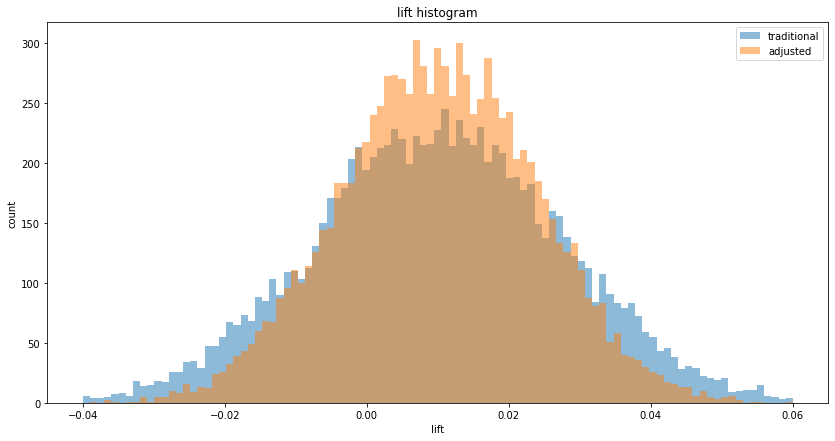

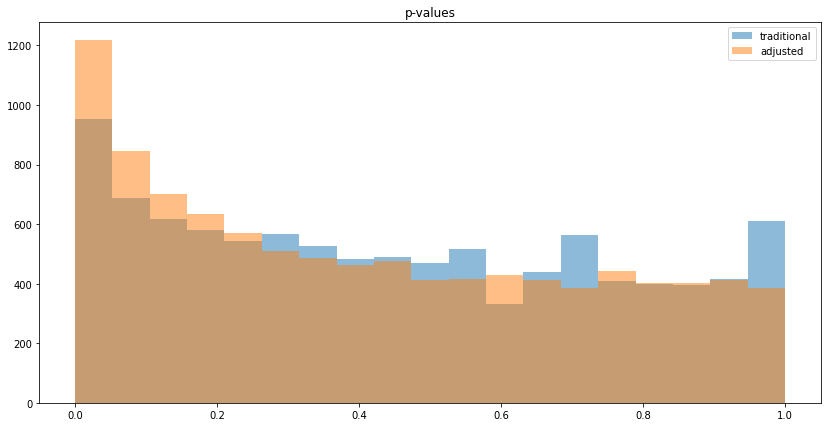

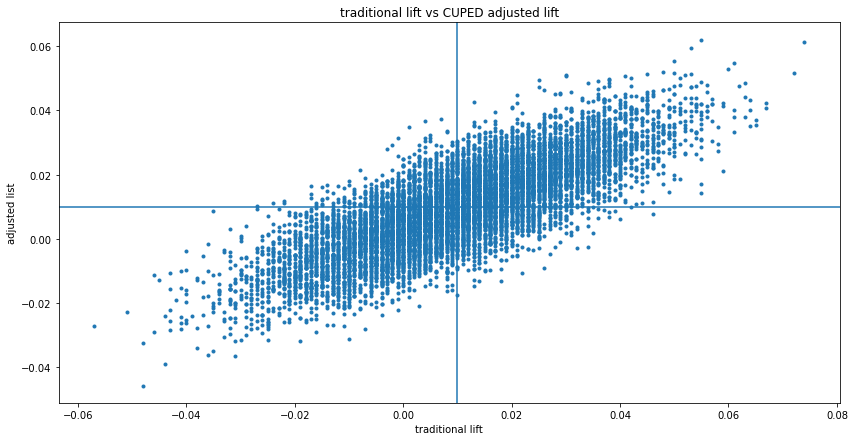

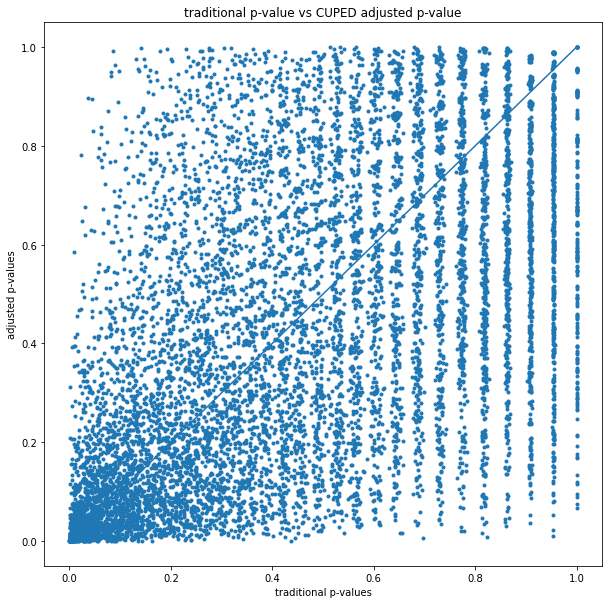

In [6]:
N = 1000
before_p = 0.1
offset_p = 0.1
treatment_lift = 0.01
num_simulations = 10*1000

print('Simulating %s A/B tests, true treatment lift is %.3f...' % (num_simulations, treatment_lift))

traditional_lifts, adjusted_lifts = [], []
traditional_pvalues, adjusted_pvalues = [], []
for i in range(num_simulations):
    print('%d/%d' % (i, num_simulations), end='\r')
    A_before, B_before, A_after, B_after = get_AB_samples(before_p, offset_p, treatment_lift, N)
    A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)
    traditional_lifts.append(lift(A_after, B_after))
    adjusted_lifts.append(lift(A_after_adjusted, B_after_adjusted))
    traditional_pvalues.append(p_value(A_after, B_after))
    adjusted_pvalues.append(p_value(A_after_adjusted, B_after_adjusted))
    
print('Traditional    A/B testing, mean lift = %.3f, variance of lift = %.5f' % (mean(traditional_lifts), cov(traditional_lifts)))
print('CUPED adjusted A/B testing, mean lift = %.3f, variance of lift = %.5f' % (mean(adjusted_lifts), cov(adjusted_lifts)))

large_N = 1000*1000
A_before, B_before, A_after, B_after = get_AB_samples(before_p, offset_p, treatment_lift, N)
elr = expected_lift_ratio(A_before, B_before, A_after, B_after)
print('CUPED lift variance / tradititional lift variance = %.3f (expected = %.3f)' % (cov(adjusted_lifts)/cov(traditional_lifts), elr))

bins = linspace(-0.04, 0.06, 100)
plt.figure(figsize=(14, 7))
plt.hist(traditional_lifts, bins, alpha=0.5, label='traditional')
plt.hist(adjusted_lifts,    bins, alpha=0.5, label='adjusted')
plt.xlabel('lift')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('lift histogram')
plt.show()

bins = linspace(0, 1, 20)
plt.figure(figsize=(14, 7))
plt.hist(traditional_pvalues, bins, alpha=0.5, label='traditional')
plt.hist(adjusted_pvalues,    bins, alpha=0.5, label='adjusted')
plt.legend(loc='upper right')
plt.title('p-values')
plt.show()

plt.figure(figsize=(14, 7))
plt.scatter(traditional_lifts, adjusted_lifts, marker='.')
plt.xlabel('traditional lift')
plt.ylabel('adjusted list')
plt.axvline(x=treatment_lift)
plt.axhline(y=treatment_lift)
plt.title('traditional lift vs CUPED adjusted lift')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot([0,1],[0,1])
plt.scatter(traditional_pvalues, adjusted_pvalues, marker='.')
plt.xlabel('traditional p-values')
plt.ylabel('adjusted p-values')
plt.title('traditional p-value vs CUPED adjusted p-value')
plt.show()

In [7]:
def get_AB_samples_nocorr(before_p, treatment_lift, N):
    A_before = [before_p] * N
    B_before = [before_p] * N
    A_after = [before_p] * N
    B_after = [before_p + treatment_lift] * N
    return lmd(A_before), lmd(B_before), lmd(A_after), lmd(B_after)

In [8]:
N = 10*1000
before_p = 0.1
offset_p = 0.1
treatment_lift = 0.01

A_before, B_before, A_after, B_after = get_AB_samples_nocorr(before_p, treatment_lift, N)
A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)

print('A mean before = %.3f, A mean after = %.3f, A mean after adjusted = %.3f' % (mean(A_before), mean(A_after), mean(A_after_adjusted)))
print('B mean be|fore = %.3f, B mean after = %.3f, B mean after adjusted = %.3f' % (mean(B_before), mean(B_after), mean(B_after_adjusted)))
print('Traditional    A/B test evaluation, lift = %.3f, p-value = %.3f' % (lift(A_after, B_after), p_value(A_after, B_after)))
print('CUPED adjusted A/B test evaluation, lift = %.3f, p-value = %.3f' % (lift(A_after_adjusted, B_after_adjusted), p_value(A_after_adjusted, B_after_adjusted)))

A mean before = 0.096, A mean after = 0.101, A mean after adjusted = 0.101
B mean be|fore = 0.104, B mean after = 0.110, B mean after adjusted = 0.110
Traditional    A/B test evaluation, lift = 0.009, p-value = 0.038
CUPED adjusted A/B test evaluation, lift = 0.009, p-value = 0.039


In [9]:
counts = defaultdict(int)
for b, a in zip(A_before, A_after):
    counts[(b, a)] += 1
    counts[(b)] += 1

print('P(before = 0) = %.2f' % (counts[(0)]/(counts[(0)]+counts[(1)])))
print('P(after = 1 | before = 0) = %.2f' % (counts[(0, 1)]/counts[(0)]))
print('P(after = 0 | before = 0) = %.2f' % (counts[(0, 0)]/counts[(0)]))
print('P(before = 1) = %.2f' % (counts[(1)]/(counts[(0)]+counts[(1)])))
print('P(after = 1 | before = 1) = %.2f' % (counts[(1, 1)]/counts[(1)]))
print('P(after = 0 | before = 1) = %.2f' % (counts[(1, 0)]/counts[(1)]))

P(before = 0) = 0.90
P(after = 1 | before = 0) = 0.10
P(after = 0 | before = 0) = 0.90
P(before = 1) = 0.10
P(after = 1 | before = 1) = 0.10
P(after = 0 | before = 1) = 0.90


Simulating 10000 A/B tests, true treatment lift is 0.010...
Traditional    A/B testing, mean lift = 0.010, variance of lift = 0.00019
CUPED adjusted A/B testing, mean lift = 0.010, variance of lift = 0.00019
CUPED lift variance / tradititional lift variance = 0.999 (expected = 1.000)


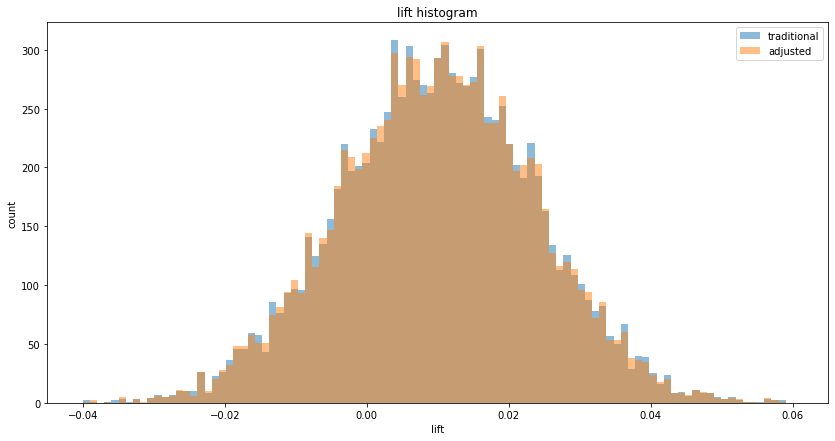

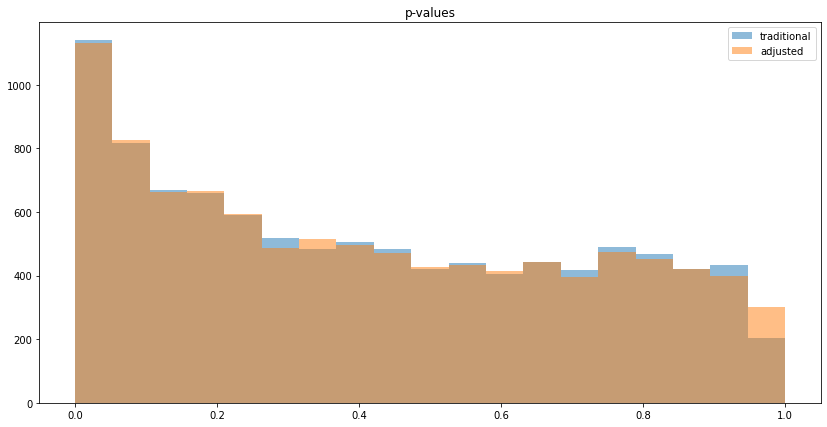

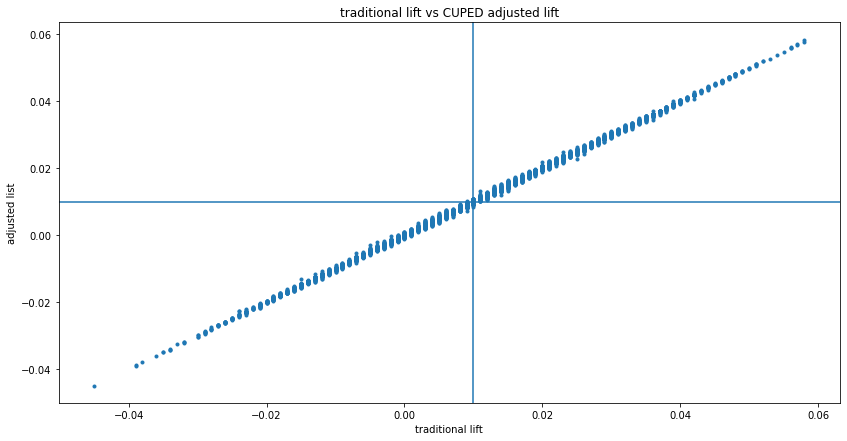

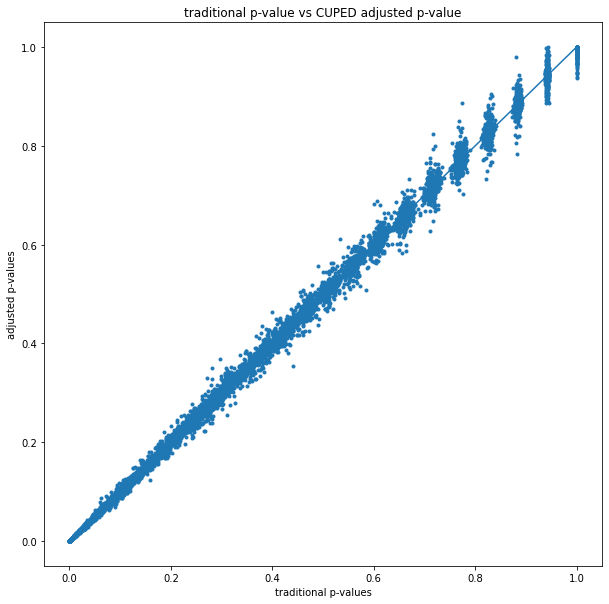

In [10]:
N = 1000
before_p = 0.1
offset_p = 0.1
treatment_lift = 0.01
num_simulations = 10*1000

print('Simulating %s A/B tests, true treatment lift is %.3f...' % (num_simulations, treatment_lift))

traditional_lifts, adjusted_lifts = [], []
traditional_pvalues, adjusted_pvalues = [], []
for i in range(num_simulations):
    print('%d/%d' % (i, num_simulations), end='\r')
    A_before, B_before, A_after, B_after = get_AB_samples_nocorr(before_p, treatment_lift, N)
    A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)
    traditional_lifts.append(lift(A_after, B_after))
    adjusted_lifts.append(lift(A_after_adjusted, B_after_adjusted))
    traditional_pvalues.append(p_value(A_after, B_after))
    adjusted_pvalues.append(p_value(A_after_adjusted, B_after_adjusted))
    
print('Traditional    A/B testing, mean lift = %.3f, variance of lift = %.5f' % (mean(traditional_lifts), cov(traditional_lifts)))
print('CUPED adjusted A/B testing, mean lift = %.3f, variance of lift = %.5f' % (mean(adjusted_lifts), cov(adjusted_lifts)))

large_N = 1000*1000
A_before, B_before, A_after, B_after = get_AB_samples_nocorr(before_p, treatment_lift, N)
elr = expected_lift_ratio(A_before, B_before, A_after, B_after)
print('CUPED lift variance / tradititional lift variance = %.3f (expected = %.3f)' % (cov(adjusted_lifts)/cov(traditional_lifts), elr))

bins = linspace(-0.04, 0.06, 100)
plt.figure(figsize=(14, 7))
plt.hist(traditional_lifts, bins, alpha=0.5, label='traditional')
plt.hist(adjusted_lifts,    bins, alpha=0.5, label='adjusted')
plt.xlabel('lift')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('lift histogram')
plt.show()

bins = linspace(0, 1, 20)
plt.figure(figsize=(14, 7))
plt.hist(traditional_pvalues, bins, alpha=0.5, label='traditional')
plt.hist(adjusted_pvalues,    bins, alpha=0.5, label='adjusted')
plt.legend(loc='upper right')
plt.title('p-values')
plt.show()

plt.figure(figsize=(14, 7))
plt.scatter(traditional_lifts, adjusted_lifts, marker='.')
plt.xlabel('traditional lift')
plt.ylabel('adjusted list')
plt.axvline(x=treatment_lift)
plt.axhline(y=treatment_lift)
plt.title('traditional lift vs CUPED adjusted lift')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot([0,1],[0,1])
plt.scatter(traditional_pvalues, adjusted_pvalues, marker='.')
plt.xlabel('traditional p-values')
plt.ylabel('adjusted p-values')
plt.title('traditional p-value vs CUPED adjusted p-value')
plt.show()